In [5]:
from ucimlrepo import fetch_ucirepo

student_performance = fetch_ucirepo(id=320)
X = student_performance.data.features
y = student_performance.data.targets

In [6]:
print(f"Features: {X.shape}, Target: {y.shape}")
print(f"\nTarget distribution:\n{y['G3'].apply(lambda x: 'Pass' if x >= 10 else 'Fail').value_counts()}")

Features: (649, 30), Target: (649, 3)

Target distribution:
G3
Pass    549
Fail    100
Name: count, dtype: int64


## Feature Engineering

In [7]:
import numpy as np
import pandas as pd

data = X.copy()
data['outcome'] = y['G3'].apply(lambda x: 'Pass' if x >= 10 else 'Fail')

# ORDINAL predictors
data['study_time'] = data['studytime'].map({1: '<2h', 2: '2-5h', 3: '5-10h', 4: '>10h'})
STUDY_TIME_ORDER = ['<2h', '2-5h', '5-10h', '>10h']

data['mother_education'] = data['Medu'].map({0: 'None', 1: 'Primary', 2: 'Primary', 3: 'Secondary', 4: 'Higher'})
MOTHER_EDU_ORDER = ['None', 'Primary', 'Secondary', 'Higher']

data['failures_cat'] = data['failures'].apply(lambda x: str(x) if x < 3 else '3+')
FAILURES_ORDER = ['0', '1', '2', '3+']

# FLOATING predictor (ordinal + missing category)
np.random.seed(42)
absence_bins = pd.cut(data['absences'], bins=[-1, 0, 5, 10, 100], labels=['None', 'Low', 'Medium', 'High'])
data['absence_level'] = absence_bins.astype(str)
missing_mask = np.random.rand(len(data)) < 0.10
data.loc[missing_mask, 'absence_level'] = 'miss'
ABSENCE_ORDER = ['None', 'Low', 'Medium', 'High', 'miss']

print(f"Dataset: {data.shape[0]} samples")
print(f"Outcome: {dict(data['outcome'].value_counts())}")

Dataset: 649 samples
Outcome: {'Pass': np.int64(549), 'Fail': np.int64(100)}


In [8]:
import sys
sys.path.insert(0, '..')

import importlib
for mod in [k for k in sys.modules if k.startswith('chaid')]:
    del sys.modules[mod]

from chaid import CHAIDTree, PredictorConfig, PredictorType
from chaid.visualization import (
    get_all_pairwise_at_step, 
    get_successive_merges_table,
    pairwise_chi_square_table,
    visualize_tree,
    get_predictor_summary_table
)

In [9]:
predictors = ['study_time', 'mother_education', 'failures_cat', 'absence_level', 'sex', 'higher', 'internet']
X_chaid = data[predictors].copy()
y_chaid = data['outcome']

predictor_configs = {
    'study_time': PredictorConfig('study_time', PredictorType.ORDINAL, STUDY_TIME_ORDER),
    'mother_education': PredictorConfig('mother_education', PredictorType.ORDINAL, MOTHER_EDU_ORDER),
    'failures_cat': PredictorConfig('failures_cat', PredictorType.ORDINAL, FAILURES_ORDER),
    'absence_level': PredictorConfig('absence_level', PredictorType.FLOATING, ABSENCE_ORDER, 'miss'),
    'sex': PredictorConfig('sex', PredictorType.NOMINAL),
    'higher': PredictorConfig('higher', PredictorType.NOMINAL),
    'internet': PredictorConfig('internet', PredictorType.NOMINAL)
}

## Tree with Bonferroni Correction

In [10]:
tree_bonf = CHAIDTree(
    alpha_merge=0.05,
    alpha_split=0.049,
    max_depth=3,
    min_parent_size=30,
    min_child_size=15,
    apply_bonferroni=True
)
tree_bonf.fit(X_chaid, y_chaid, predictor_types=predictor_configs)

print(f"WITH Bonferroni: Nodes={len(tree_bonf.nodes)}, Depth={tree_bonf.get_depth()}, Leaves={len(tree_bonf.get_leaves())}")
print(f"Root split: {tree_bonf.root.split_variable}")

WITH Bonferroni: Nodes=7, Depth=3, Leaves=4
Root split: failures_cat


In [11]:
print(tree_bonf.print_tree())

Node 0 (n=649)
   Split: failures_cat
   χ²=102.34, p=0.0000
   p_adj=0.0000 (×3)
   ├─ failures_cat = 0
   │  Node 1 (n=549)
   │     Split: higher
   │     χ²=40.06, p=0.0000
   │     p_adj=0.0000 (×1)
   │     ├─ higher = no
   │     │  Leaf 2 (n=36)
   │     │     Modal: Pass (22/36)
   │     ├─ higher = yes
   │     │  Node 3 (n=513)
   │     │     Split: study_time
   │     │     χ²=6.97, p=0.0083
   │     │     p_adj=0.0248 (×3)
   │     │     ├─ study_time = {np.str_('2-5h'), np.str_('<2h')}
   │     │     │  Leaf 4 (n=395)
   │     │     │     Modal: Pass (360/395)
   │     │     ├─ study_time = {np.str_('5-10h'), np.str_('>10h')}
   │     │     │  Leaf 5 (n=118)
   │     │     │     Modal: Pass (116/118)
   ├─ failures_cat = {np.str_('2'), np.str_('3+'), np.str_('1')}
   │  Leaf 6 (n=100)
   │     Modal: Pass (51/100)
None


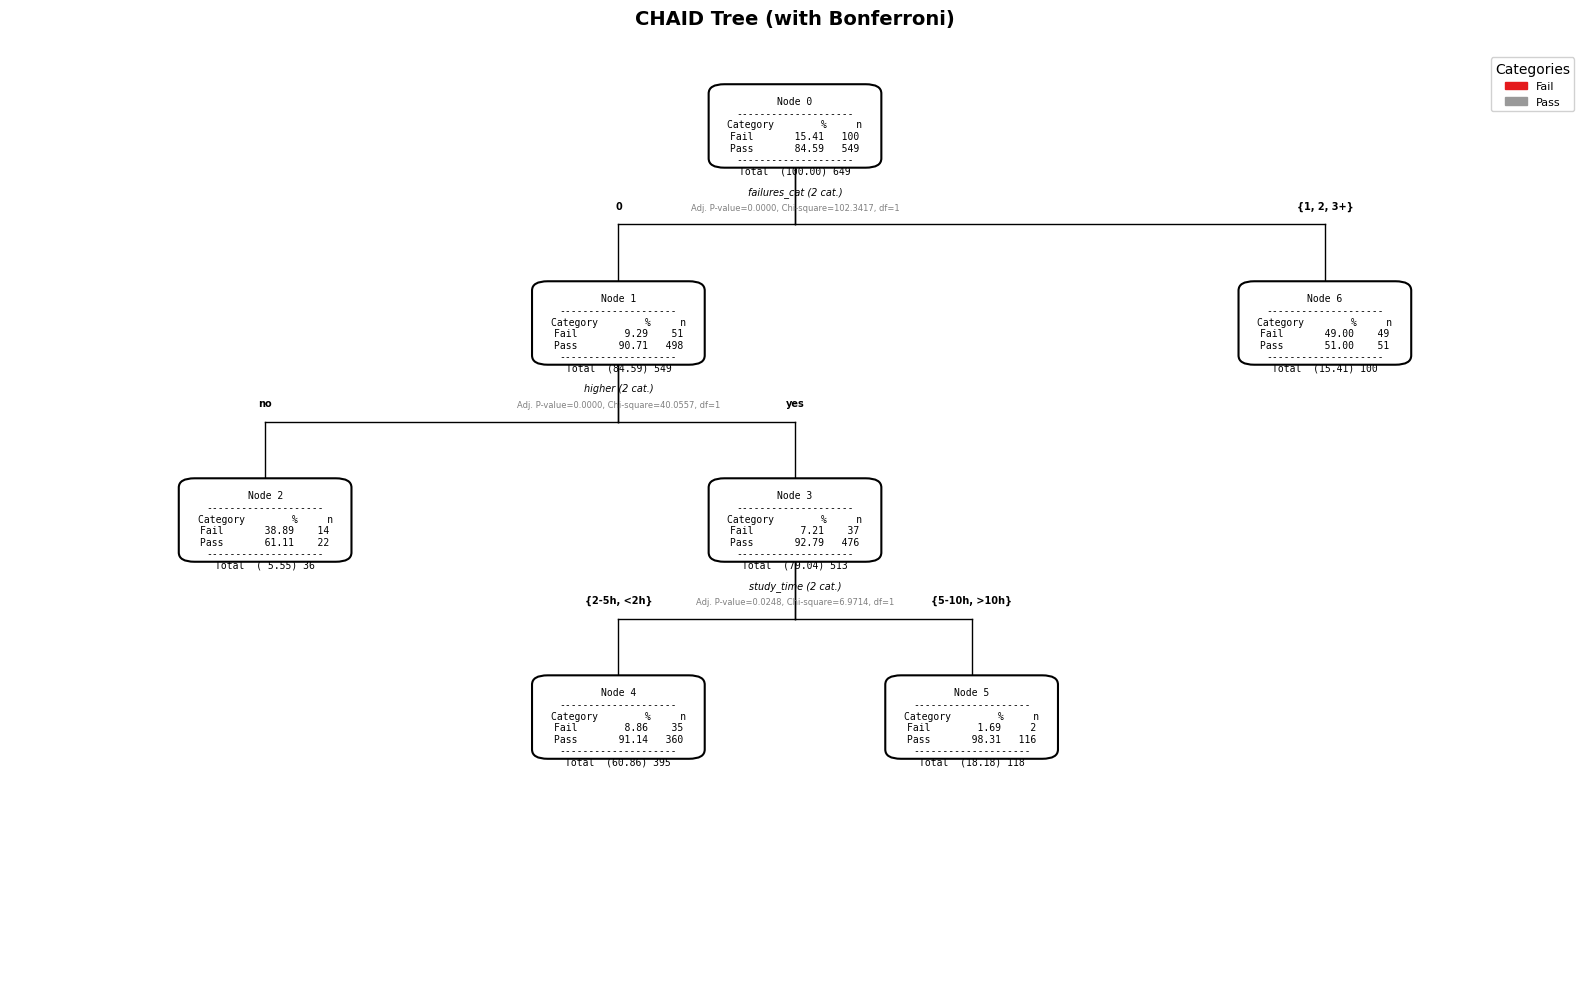

In [12]:
fig = visualize_tree(tree_bonf, method="plot", figsize=(16, 10), title="CHAID Tree (with Bonferroni)")
fig.savefig('chaid_tree_bonferroni.png', dpi=150, bbox_inches='tight')

## Tree without Bonferroni Correction

In [13]:
tree_no_bonf = CHAIDTree(
    alpha_merge=0.05,
    alpha_split=0.049,
    max_depth=3,
    min_parent_size=30,
    min_child_size=15,
    apply_bonferroni=False
)
tree_no_bonf.fit(X_chaid, y_chaid, predictor_types=predictor_configs)

print(f"WITHOUT Bonferroni: Nodes={len(tree_no_bonf.nodes)}, Depth={tree_no_bonf.get_depth()}, Leaves={len(tree_no_bonf.get_leaves())}")
print(f"Root split: {tree_no_bonf.root.split_variable}")

WITHOUT Bonferroni: Nodes=7, Depth=3, Leaves=4
Root split: failures_cat


In [14]:
print(tree_no_bonf.print_tree())

Node 0 (n=649)
   Split: failures_cat
   χ²=102.34, p=0.0000
   ├─ failures_cat = 0
   │  Node 1 (n=549)
   │     Split: higher
   │     χ²=40.06, p=0.0000
   │     ├─ higher = no
   │     │  Leaf 2 (n=36)
   │     │     Modal: Pass (22/36)
   │     ├─ higher = yes
   │     │  Node 3 (n=513)
   │     │     Split: study_time
   │     │     χ²=6.97, p=0.0083
   │     │     ├─ study_time = {np.str_('2-5h'), np.str_('<2h')}
   │     │     │  Leaf 4 (n=395)
   │     │     │     Modal: Pass (360/395)
   │     │     ├─ study_time = {np.str_('5-10h'), np.str_('>10h')}
   │     │     │  Leaf 5 (n=118)
   │     │     │     Modal: Pass (116/118)
   ├─ failures_cat = {np.str_('2'), np.str_('3+'), np.str_('1')}
   │  Leaf 6 (n=100)
   │     Modal: Pass (51/100)
None


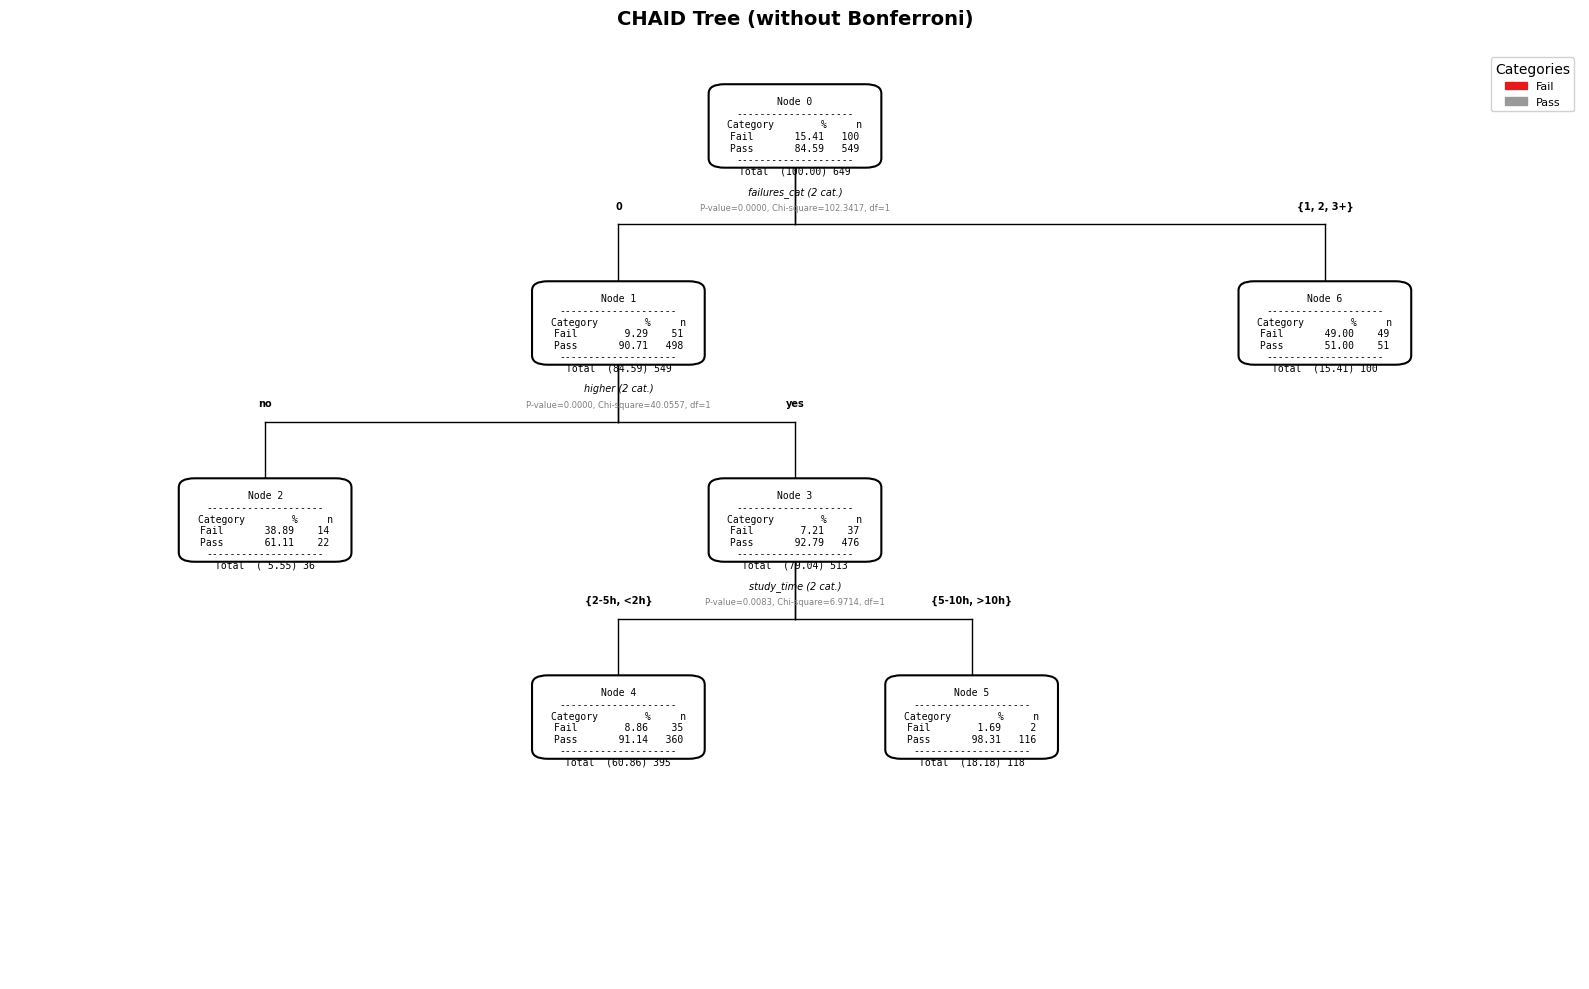

In [15]:
fig = visualize_tree(tree_no_bonf, method="plot", figsize=(16, 10), title="CHAID Tree (without Bonferroni)")
fig.savefig('chaid_tree_no_bonferroni.png', dpi=150, bbox_inches='tight')

## Pairwise Chi-Square Tables by Predictor Type

In [16]:
# ORDINAL predictor: failures_cat (only adjacent pairs)
print("ORDINAL: failures_cat")
print("=" * 60)
print(get_all_pairwise_at_step(tree_bonf, 0, 'failures_cat', step=0))
_, table = get_successive_merges_table(tree_bonf, 0, 'failures_cat')
print(table)

ORDINAL: failures_cat
Initial pairwise table (before any merging)

Groups:
  [1] 0
  [2] 1
  [3] 2
  [4] 3+

                 1           2           3           4
------------------------------------------------------
     1           —       70.94                        
     2      0.0000           —        0.10            
     3                  0.7565           —        0.62
     4                              0.4308           —
------------------------------------------------------
Upper triangle: χ² values | Lower triangle: p-values
(Only adjacent pairs computed for ORDINAL predictor)

→ Most similar pair: [2] and [3] (χ²=0.10, p=0.7565)
╔════════════════════════════════════════════════════════════════════════════╗
║                          TABLE: Successive Merges                          ║
║                     Predictor: failures_cat at Node 0                      ║
╠════════════════════════════════════════════════════════════════════════════╣
║ Iteration  │     Merge/Split

In [17]:
# NOMINAL predictor: higher (all pairs)
print("NOMINAL: higher")
print("=" * 60)
print(get_all_pairwise_at_step(tree_bonf, 0, 'higher', step=0))
_, table = get_successive_merges_table(tree_bonf, 0, 'higher')
print(table)

NOMINAL: higher
Initial pairwise table (before any merging)

Groups:
  [1] no
  [2] yes

                 1           2
------------------------------
     1           —       62.25
     2      0.0000           —
------------------------------
Upper triangle: χ² values | Lower triangle: p-values

→ Most similar pair: [1] and [2] (χ²=62.25, p=0.0000)
╔════════════════════════════════════════════════════════════════════════════╗
║                          TABLE: Successive Merges                          ║
║                        Predictor: higher at Node 0                         ║
╠════════════════════════════════════════════════════════════════════════════╣
║ Iteration  │     Merge/Split      │  Chi-square  │   p-value    │  Decision  ║
╠════════════════════════════════════════════════════════════════════════════╣
║     1      │        {1,2}         │    62.25     │    0.00%     │  Stopped   ║
╚════════════════════════════════════════════════════════════════════════════╝

Category La

In [18]:
# FLOATING predictor: absence_level (adjacent + floating 'miss' with all)
print("FLOATING: absence_level")
print("=" * 60)
print(get_all_pairwise_at_step(tree_bonf, 0, 'absence_level', step=0))
_, table = get_successive_merges_table(tree_bonf, 0, 'absence_level')
print(table)

FLOATING: absence_level
Initial pairwise table (before any merging)

Groups:
  [1] None
  [2] Low
  [3] Medium
  [4] High
  [5] miss

                 1           2           3           4           5
------------------------------------------------------------------
     1           —        0.09                                1.47
     2      0.7652           —        2.05                    0.95
     3                  0.1518           —        0.39        0.07
     4                              0.5310           —        0.64
     5      0.2247      0.3309      0.7917      0.4239           —
------------------------------------------------------------------
Upper triangle: χ² values | Lower triangle: p-values
(Adjacent + floating category pairs computed for FLOATING predictor)

→ Most similar pair: [3] and [5] (χ²=0.07, p=0.7917)
╔════════════════════════════════════════════════════════════════════════════╗
║                          TABLE: Successive Merges                        

## Predictor Summary

In [19]:
print(get_predictor_summary_table(tree_bonf, node_id=0))

╔════════════════════════════════════════════════════════════════════════════════════════════════════╗
║                          TABLE 10: Summary of Possible First Level Splits                          ║
╠════════════════════════════════════════════════════════════════════════════════════════════════════╣
║ Predictor            │ Type     │  #cat │  #grp │     Chi-sq │  df │        p-value │ Selected ║
╠────────────────────────────────────────────────────────────────────────────────────────────────────╣
║ failures_cat         │ ORDINAL  │     4 │     2 │     102.34 │   1 │   0.0000000000 │        ★ ║
║ higher               │ NOMINAL  │     2 │     2 │      62.25 │   1 │   0.0000000000 │          ║
║ study_time           │ ORDINAL  │     4 │     3 │      19.25 │   2 │       0.000198 │          ║
║ mother_education     │ ORDINAL  │     4 │     2 │      10.09 │   1 │       0.004474 │          ║
║ internet             │ NOMINAL  │     2 │     2 │       5.05 │   1 │       0.024620 │      